In [1]:
from ipytables import *

In [180]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 10, 5
pl.rcParams['text.usetex'] = False
def savefigure(fname):
    from IPython.display import FileLink
    pl.savefig("../../" + fname,bbox_inches='tight')
    FileLink(fname)

In [3]:
import itertools
import os.path
import csv
import numpy as np
import scipy.spatial
import pandas as pd
pd.options.display.max_rows=20
pd.options.display.max_seq_items = 100
pd.options.display.max_colwidth = 100
import sklearn
from sklearn.decomposition import PCA

In [4]:
def normalise_name(name):
    return name.replace("__","-").replace("_"," ").upper()
def normalise_names(names):
    return [normalise_name(name) for name in names]

In [6]:
#try:
#os.chdir("prepared_corpora/opinosis/")

#os.chdir("msrp")
os.chdir("prepared_corpora/msrp/")
#except FileNotFoundError:
#    pass

In [7]:
def load_pf_group_index():
    df = pd.read_csv("./phrase_groups.csv")
    df.set_index(["paraphrase_group_index", "phrase_index"], inplace=True)
    return df
df = load_pf_group_index()
df["tokenized_phrases"]=[line.strip() for line in open("tokenized_phrases.txt","r")]


In [8]:
df["pv__dm"]=list(np.loadtxt("outVectors_wiki_sentence_concat_pvdm.csv", delimiter=","))
df["pv__dbow"]=list(np.loadtxt("outVectors_wiki_sentence_dbow.csv", delimiter=","))
df["urae"]=list(np.loadtxt("outVectors_RAE2011.csv", delimiter=","))
df["mowe"]=list(np.loadtxt("outVectors_mowe.csv", delimiter=","))
df["sowe"]=list(np.loadtxt("outVectors_sowe.csv", delimiter=","))
#df["howe"]=list(np.loadtxt("outVectors_howe.csv", delimiter=","))
df["bow"]=list(np.loadtxt("outVectors_bow.csv", delimiter=","))


In [9]:
#Just consider paraphrase groups of a certain size
df = df.groupby(level=0).filter(lambda group: len(group)>=3)

In [10]:
def get_true_classes(series):
    return np.asarray([ii[0] for ii in series.index])

In [34]:
#df["rand"]=[np.random.rand(300) for row in range(len(df))]

In [ ]:

#df["pca_bow"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(list(df.bow))))
#df["pca_howe"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(list(df.howe))))

In [ ]:
#for base in "pv__dm pv__dbow urae".split():
#    df[base+"_mowe"] = df[base].combine(df.mowe, func=lambda a,b: np.concatenate((a,b)))
#    df["pca_"+base+"_bow"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(df[base+"_bow"])))

In [ ]:
#for base in "pv__dm pv__dbow urae".split():
#    df[base+"_bow"] = df[base].combine(df.bow, func=lambda a,b: np.concatenate((a,b)))
#    df["pca_"+base+"_bow"] = list(PCA(300, whiten=False).fit_transform(np.row_stack(df[base+"_bow"])))


In [ ]:
#Very Low Dimentionality:
#for base in "pv__dm pv__dbow urae mowe bow".split():
#    df[base] = list(PCA(32, whiten=False).fit_transform(np.row_stack(df[base])))


In [36]:
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn import tree
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

#class_weight = {key: 1/value for (key, value) in Counter(training_data.debate_type).items()}

def classify(column, classifier, train_data, test_data, train_labels, test_labels):
    train_data_X = np.row_stack(train_data[column])
    test_data_X = np.row_stack(test_data[column])

    classifier.fit(train_data_X, train_labels)
    
    return classifier.score(test_data_X, test_labels)


classifiers = [LinearSVC(class_weight="auto",  max_iter=20000, C=0.1),
               LinearSVC(class_weight="auto",  max_iter=20000), 
               LinearSVC(class_weight="auto",  max_iter=20000, C=5),
               LinearSVC(class_weight="auto",  max_iter=20000, C=10),
               LinearSVC(class_weight="auto",  max_iter=20000, C=100),
               LinearSVC(class_weight="auto",  max_iter=20000, C=1000),
               LinearSVC(class_weight="auto",  max_iter=20000, C=10000)
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=10),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=100),        
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=1000),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=10000),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=100000),
       #SVC(class_weight="auto",  max_iter=20000, kernel='rbf', C=1000000),
        #OneVsRestClassifier(SVC(class_weight="auto",  max_iter=20000, kernel='rbf')),
        #tree.DecisionTreeClassifier(class_weight="auto")
        
        
       ]


In [37]:
from sklearn import cross_validation
n_folds =  df.tokenized_phrases.groupby(level=0).agg(len).min()
print(str(n_folds)+"-fold validation")
classify_results = pd.DataFrame(index=classifiers)
for column in df.columns[1:]:
    for classifier in classifiers:
        cv_res = cross_validation.cross_val_score(classifier, 
                                          X = np.row_stack(df[column]),
                                          y = get_true_classes(df),
                                          cv= n_folds,
                                          n_jobs=-1
                                        
                                          )
        classify_results.loc[classifier,(column)] = cv_res.mean()
        #classify_results.loc[svm,(column+"_std")] = cv_res.std()

classify_results

3-fold validation


,pv__dm,pv__dbow,urae,mowe,sowe,bow,rand
"LinearSVC(C=0.1, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",32.64%,88.02%,44.06%,96.29%,98.02%,98.37%,0.48%
"LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",60.38%,89.93%,50.01%,97.44%,97.90%,98.37%,0.47%
"LinearSVC(C=5, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",73.84%,89.26%,51.14%,97.79%,97.79%,98.37%,0.47%
"LinearSVC(C=10, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",77.43%,88.79%,50.88%,97.91%,97.79%,98.37%,0.47%
"LinearSVC(C=100, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",78.00%,88.55%,49.60%,97.79%,97.79%,98.37%,0.47%
"LinearSVC(C=1000, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",74.15%,88.55%,48.78%,97.79%,97.79%,98.37%,0.47%
"LinearSVC(C=10000, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",73.45%,88.42%,48.78%,97.79%,97.79%,98.37%,0.47%


In [20]:
#The corr
from copy import deepcopy
from sklearn.cross_validation import StratifiedKFold
X = np.row_stack(df["bow"])
y = get_true_classes(df)
n_folds = df.tokenized_phrases.groupby(level=0).agg(len).min()

pca_bow_res = pd.DataFrame()
for ii_fold, (test_indexes, train_indexes) in enumerate(StratifiedKFold( y, n_folds)):
    X_train = X[train_indexes]
    y_train = y[train_indexes]
    X_test = X[test_indexes]
    y_test = y[test_indexes]
    
    pca = PCA(300)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    
    for classifier_index in classifiers:
        classifier = deepcopy(classifier_index)
        classifier.fit(X_train, y_train)
        pca_bow_res.loc[classifier_index,(ii_fold)] = classifier.score(X_test, y_test)
    
    
pca_bow_res

/usr/local/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,0,1,2
"LinearSVC(C=0.1, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.978221,0.975945,0.984615
"LinearSVC(C=1.0, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.976407,0.975945,0.982906
"LinearSVC(C=5, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.976407,0.975945,0.982906
"LinearSVC(C=10, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.976407,0.975945,0.982906
"LinearSVC(C=100, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.976407,0.975945,0.982906
"LinearSVC(C=1000, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.976407,0.975945,0.982906
"LinearSVC(C=10000, class_weight='auto', dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=20000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.976407,0.975945,0.982906


In [21]:
classify_results["pca_bow"] = pca_bow_res.mean(axis=1)

pd.options.display.float_format = lambda x: '{:.2f}%'.format(x*100)
classify_results.max()

pv__dm     78.00%
pv__dbow   89.93%
urae       51.14%
mowe       97.91%
sowe       98.02%
bow        98.37%
pca_bow    97.96%
dtype: float64

In [22]:
from sklearn.cross_validation import StratifiedShuffleSplit
from collections import OrderedDict

best_classifiers = classify_results.idxmax().to_dict()
actual_classes=OrderedDict()

y=get_true_classes(df)
train_indexes, test_indexes = list(*StratifiedShuffleSplit(y,1,test_size=1/n_folds))
y_train = y[train_indexes]
y_test = y[test_indexes]




for model in classify_results.columns:
    
    X = np.row_stack(df[model if model!="pca_bow" else "bow"])
    X_train = X[train_indexes]
    X_test = X[test_indexes]
    
    if model == "pca_bow":
        pca = PCA(300)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    
    classifier = best_classifiers[model]
    classifier.fit(X_train,y_train)
    actual_classes[model] = classifier.predict(X_test)


In [181]:
import matplotlib
def plot_matrix(numer,denom, labels, cmap=matplotlib.cm.Blues):
    labels=list(labels)
    pl.title(os.path.basename(os.getcwd()).upper(),  fontweight='bold')  
    cmap.set_bad('w')
    
    mat = np.asarray((numer/denom).values,dtype=np.float32)
    mask =  np.tri(mat.shape[0], k=0)
    mat = np.ma.array(mat, mask=mask)
    #mat=100*mat #Conver to percent
    
    pl.imshow(mat, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    pl.colorbar()
    
    for ii in range(0,len(labels)):
        iiL = labels[len(labels)-ii-1]
        for jj in range(ii+1,len(labels)):
            jjL=labels[len(labels)-jj-1]
            posX = len(labels)-ii-1
            posY = len(labels)-jj-1
            #text =  "%i/%i" % (numer.loc[iiL,jjL], denom.loc[iiL,jjL])
            text =  r"$\frac{%i}{%i}$" % (numer.loc[iiL,jjL], denom.loc[iiL,jjL])
            pl.text(posX,posY,text,
                size='xx-large', family='sans-serif',
                horizontalalignment='center', verticalalignment="center",
                bbox=dict(facecolor='white', alpha=0.9, pad=10)
               )
    
    fig = pl.gcf()
    ax = pl.gca()
        
    pl.xticks([])
    pl.yticks([])
    labels = normalise_names(labels)
    labels.reverse()
    for ii,label in enumerate(labels):
        pos = len(labels)-ii-1
        shift = -0.01 if len(label)<7 else -0.1
        pl.text(pos+shift,pos,label,horizontalalignment='center', verticalalignment="center" )
        
        xs = np.asarray([ii,ii+1,ii+1])-0.5
        ys = np.asarray([ii,ii ,ii+1])-0.5-0.025
        ax.add_line(matplotlib.lines.Line2D(xs,ys, c='k', linewidth=1, snap=True))
    
    
    ax.add_line(matplotlib.lines.Line2D([0.5,len(labels)-0.51,len(labels)-0.51],[-0.5,-0.5,len(labels)-1.51], 
                                        c='k',
                                        linewidth=1,
                                        snap=True,
                                        clip_on=False
                                       ))
    pl.setp(ax,'frame_on',False)

    pl.tight_layout()
    



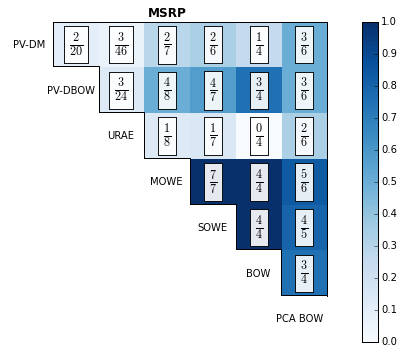

In [182]:

mistake_agreement = pd.DataFrame(columns=actual_classes.keys(), index=actual_classes.keys())
both_wrong = pd.DataFrame(columns=actual_classes.keys(), index=actual_classes.keys())
for model1 in actual_classes.keys():
    for model2 in actual_classes.keys():
        classes1=actual_classes[model1]
        classes2=actual_classes[model2]
        
        mistake_indexes = np.logical_and(classes1!=y_test, classes2!=y_test)
        both_wrong.loc[model1,model2] = mistake_indexes.sum()
        
        
        mistake_agreement.loc[model1,model2] = (classes1[mistake_indexes]==classes2[mistake_indexes]).sum()
        
      
plot_matrix(mistake_agreement,both_wrong, actual_classes.keys())
mistake_agreement/both_wrong
savefigure("msrp_agree.pdf")
    


,pv__dm,pv__dbow,urae,mowe,sowe,bow,pca_bow,ground_truth
pv__dm,100.00%,80.14%,60.65%,79.42%,79.06%,78.70%,79.42%,77.26%
pv__dbow,80.14%,100.00%,55.96%,91.34%,90.97%,89.89%,90.61%,88.45%
urae,60.65%,55.96%,100.00%,53.07%,52.71%,51.62%,52.35%,50.18%
mowe,79.42%,91.34%,53.07%,100.00%,99.64%,98.56%,99.28%,97.11%
sowe,79.06%,90.97%,52.71%,99.64%,100.00%,98.92%,98.92%,97.47%
bow,78.70%,89.89%,51.62%,98.56%,98.92%,100.00%,99.28%,98.56%
pca_bow,79.42%,90.61%,52.35%,99.28%,98.92%,99.28%,100.00%,97.83%
ground_truth,77.26%,88.45%,50.18%,97.11%,97.47%,98.56%,97.83%,100.00%


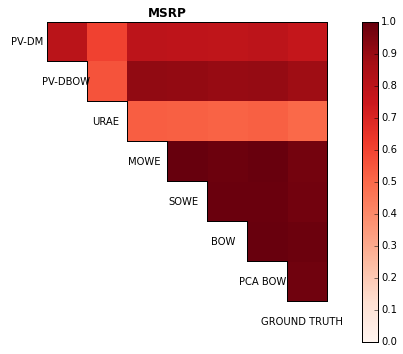

In [25]:
difficulty_agreement = pd.DataFrame(columns=actual_classes.keys(), index=actual_classes.keys())

for model1 in actual_classes.keys():
    for model2 in actual_classes.keys():
        classes1=actual_classes[model1]
        classes2=actual_classes[model2]
        
        difficulty_agreement.loc[model1,model2] = sklearn.metrics.jaccard_similarity_score(classes1!=y_test,
                                                                                           classes2!=y_test)
        
plot_matrix(np.asarray( difficulty_agreement.values, dtype=np.float32), actual_classes.keys(),matplotlib.cm.Reds)
difficulty_agreement

        
        

,pv__dm,pv__dbow,urae,mowe,sowe,bow,pca_bow
pv__dm,100.00%,73.65%,45.13%,77.62%,77.62%,77.62%,78.34%
pv__dbow,73.65%,100.00%,48.38%,89.89%,89.89%,89.53%,89.53%
urae,45.13%,48.38%,100.00%,50.54%,50.54%,50.18%,50.90%
mowe,77.62%,89.89%,50.54%,100.00%,99.64%,98.56%,98.92%
sowe,77.62%,89.89%,50.54%,99.64%,100.00%,98.92%,98.56%
bow,77.62%,89.53%,50.18%,98.56%,98.92%,100.00%,98.92%
pca_bow,78.34%,89.53%,50.90%,98.92%,98.56%,98.92%,100.00%


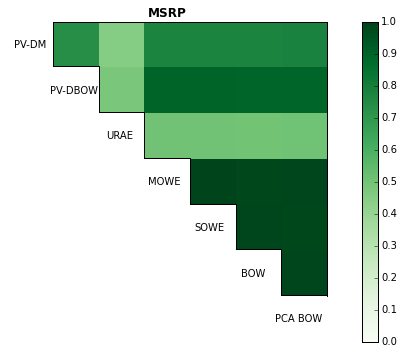

In [28]:
actual_classes["ground_truth"] = y_test
import sklearn
agreement = pd.DataFrame(columns=actual_classes.keys(), index=actual_classes.keys())
for model1 in actual_classes.keys():
    for model2 in actual_classes.keys():
        agreement.loc[model1,model2] = sklearn.metrics.accuracy_score(actual_classes[model1],actual_classes[model2])
plot_matrix(np.asarray( agreement.values, dtype=np.float32), actual_classes.keys(), matplotlib.cm.Greens)

agreement

#Wei's method

0. Normalise all embeddings for each model
1. within each paraphrase group, for each model, work out average pair-wise cosine similarity (or distance)
  1. the ground truth in this case should be horizontal x axis, which means the best values that each model gets should be close to zero (if you use similarity, rather than distance). So the model with an overall trend of low similarity values capture the semantics better.
2. treat each model's average similarity/distance for the paraphrase groups as a time series, do a z-normalisation () the time (horizontal) axis is the paraphrase group index, and the y axis is the similarity value after the z-normalisation
3. measure the similarity between the four model time series, pair-wise using Euclidean distance to see which model agrees with each other. 


In [ ]:
import scipy.spatial.distance as distance

def angular_dist(a,b):
    cos_sim = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return 1- np.arccos(cos_sim)/np.pi


In [ ]:
def get_std(series):
    xs=np.row_stack(series)
    std_dev = xs.std(axis=0)
    std_dev[std_dev==0.0]=1.0
    return list(std_dev)
def get_mean(series):
    xs = np.row_stack(series)
    return list(xs.mean(axis=0))

dfs = (df.iloc[:,1:]-df.iloc[:,1:].apply(get_mean))/df.iloc[:,1:].apply(get_std)



In [ ]:
def get_group_sim(group):
    xs = np.row_stack(group)
    #cosine_sim = (1-distance.pdist(xs, 'cosine'))
    dist = distance.pdist(xs,angular_dist)
    return dist.mean()

group_sims = dfs.groupby(level=0).agg(get_group_sim)
group_sims.hist(bins=np.linspace(0,1,50), sharex=True, sharey=True)
group_sims.describe()

In [ ]:

def get_interrater_e_distance(ratings):
    rating_dist = distance.pdist(n_group_sims.as_matrix().T)
    return distance.squareform(rating_dist)

def z_norm(col):
    return (col-col.mean())/col.std()

n_group_sims = group_sims.apply(z_norm)


interrater_e_distance = get_interrater_e_distance(n_group_sims)
print(pd.DataFrame( interrater_e_distance, columns =n_group_sims.columns, index=n_group_sims.columns))
      
plot_matrix(interrater_e_distance, n_group_sims.columns)

In [ ]:
def get_centroid(group):
    xs = np.row_stack(group)
    return list(xs.mean(axis=0)) #Euclidean



def get_medoid(group):
    points=np.row_stack(group)
    ingroup_index = distance.cdist(points,points, 'cosine').sum(axis=1).argmin()
    return list(points[ingroup_index,:])


def get_angular_centroid(group):
    # the angular centroid is a line, here we choes an arbitairy point on it.
    # Dicussion of how normalising and adding wroks is at http://math.stackexchange.com/a/925659/1505
    points = np.row_stack(group)
    unit_points = points/np.linalg.norm(points,axis=1)[:,None]  #Normalise ot unit vectors
    return list(np.sum(unit_points,axis=0))
    

def get_group_medoids(series):
    return series.groupby(level=0).agg(get_medoid)


def get_group_centroids(series):
    return series.groupby(level=0).agg(get_centroid)


In [ ]:
def dunn_index(series):
    group_intra_distance = series.groupby(level=0).agg(get_group_sim)
    denom = group_intra_distance.max()
    group_ids = np.unique(series.index[0])
    
    for ii in group_ids:
        smallest_inter_dist = np.Inf
        for jj in group_ids:
            if ii==jj:
                continue
            #Now to find the Interclass distance
            #Lets
            Not WRITEN YET

    
    return denom

dunn_index(df.urae)

In [ ]:

#Davies-Bouldin Index 
#Modified to use angular centroid, and angular distance

def davied_bouldin_index(series):

    def av_dist_to_centroid(group):
        xs = np.row_stack(group)
        c = get_angular_centroid(group)
        return distance.cdist(xs,[c], angular_dist).mean()

    group_centroids = get_group_centroids(series)
    group_spreads = series.groupby(level=0).agg(av_dist_to_centroid)
    
    n_groups = len(group_spreads)
    
    total = 0.0
    for ii in range(n_groups):
        greatest = -1*np.Inf
        for jj in range(n_groups):
            if ii==jj:
                continue

            numer = group_spreads.iloc[ii] + group_spreads.iloc[jj] 
            denom = angular_dist(group_centroids.iloc[ii],group_centroids.iloc[jj])
            value = numer/denom
            greatest = max(greatest, value)
        total+= greatest
    return total/n_groups

            
for column in df.columns[1:]:
    print(column + " " + str(davied_bouldin_index(df.loc[:,column])))

In [ ]:
def get_classes_about_center(series, center_fun):
    group_centers = np.row_stack(series.groupby(level=0).agg(center_fun)) 
    points  = np.row_stack(series)
    class_indexes = distance.cdist(points,group_centers, 'cosine').argmin(axis=1)
    return np.asarray(series.index[class_indexes].labels[0])

def get_classes_by_similarity_to_true_classes(series):
    true_classes = get_true_classes(series)
    
    def av_dist_to_group(point, group):
        xs = np.row_stack(group)
        return distance.cdist(xs, [point], 'cosine').mean()
    
    return np.asarray([series.groupby(level=0).agg(lambda group: av_dist_to_group(point, group)).idxmin()
               for point in series])
    



def recluster_success(series):
    true_classes = get_true_classes(series)

    def get_acc(center_fun):
        classes = get_classes_about_center(series, center_fun)
        return (classes == true_classes).sum()/len(true_classes)
    
    classes = get_classes_by_similarity_to_true_classes(series)
    group_closeness_acc = (classes == true_classes).sum()/len(true_classes)

    return pd.Series([get_acc(get_centroid),
                      get_acc(get_medoid),
                      get_acc(get_angular_centroid),
                      group_closeness_acc
                     ], index="centroid_acc medoid_acc angular_centroid_acc group_closeness_acc".split()) 
    

recluster_results = pd.DataFrame()
for column in df.columns[1:]:
    recluster_results[column] = recluster_success(df[column])

recluster_results

In [ ]:
#Lets take a look at what mistakes are being made.
#We can look at the exemplary member of each class as a repressentitive,
#And can compare that for the class it was given to that for the class it should have been given

def get_exemplars(df, col_name, get_center_fun):
    series = df[col_name]
    def get_exemplar(group):
        c = get_center_fun(group)
        points=np.row_stack(group)
        ingroup_index = distance.cdist(points,[c], 'cosine').flatten().argmin()
        df_index = group.index[ingroup_index]
        return df.tokenized_phrases[df_index]
    
    return series.groupby(level=0).agg(get_exemplar)


def get_mistakes(df, col_name, get_center_fun=get_angular_centroid):
    group_exemplars = get_exemplars(df, col_name,get_center_fun)
    
    series = df[col_name]
    
    classes = get_classes(series, get_center_fun)
    
    return show_mistakes(df, classes, col_name, get_center_fun)


def show_mistakes(df, actual_classes, col_for_exemplar="bow", get_center_fun = get_angular_centroid):
    group_exemplars = get_exemplars(df, col_for_exemplar, get_center_fun)
    
    true_classes = get_true_classes(df)
    mistake_indexs = np.nonzero(actual_classes!=true_classes)
    
    ret = pd.DataFrame()
    ret["mistaken_texts"] = list(df.tokenized_phrases.iloc[mistake_indexs])
    ret["true_exemplar"] = list(group_exemplars[true_classes[mistake_indexs]])
    ret["actual_exemplar"] = list(group_exemplars[actual_classes[mistake_indexs]])
    
    return ret


In [ ]:
#show_mistakes(df, get_classes_by_similarity_to_true_classes(df.bow))

In [ ]:
#get_mistakes(df, "bow",get_angular_centroid)

In [ ]:
def get_symetry_measure(group):
    xs = np.row_stack(group)
    dist=distance.pdist(xs, angular_dist)
    c=get_angular_centroid(xs)
    dist = distance.cdist(xs, [c],angular_dist)
    return dist.std()

df.groupby(level=0).agg(get_symetry_measure).describe()
    

In [ ]:
def portion_of_points_on_bounding_box(group):
    xs = np.row_stack(group)
    on_max_border = np.any(xs==xs.max(axis=0), axis=1)
    on_min_border = np.any(xs==xs.min(axis=0), axis=1)
    on_border = on_min_border + on_max_border
    return ( on_border.sum()/len(group))

def all_points_on_bounding_box(group):
    return portion_of_points_on_bounding_box(group)==1

In [ ]:
def unit_norms(vectors):
    vecs = np.row_stack(vectors)
    unit_norms = np.linalg.norm(vecs,axis=1)
    return unit_norms#[list(row) for row in unit_vecs]

dfa = pd.DataFrame(index=df.index, columns="bow pvdm dbow mowe urae".split())
for col in dfa.columns:
    dfa.loc[:,col]=df.loc[:,col]/unit_norms(df.loc[:,col])

dfa


In [ ]:
pd.options.display.float_format=None
df.groupby(level=0).agg(all_points_on_bounding_box).sum()/len(df.groupby(level=0))

In [ ]:
pd.options.display.float_format = lambda x: '{:.2f}%'.format(x*100)
hollowness=pd.Series()
hollowness["pvdm"]=portion_of_points_on_bounding_box(df.pvdm)
hollowness["dbow"]=portion_of_points_on_bounding_box(df.dbow)
hollowness["urae"]=portion_of_points_on_bounding_box(df.urae)
hollowness["mowe"]=portion_of_points_on_bounding_box(df.mowe)
hollowness["bow"]=portion_of_points_on_bounding_box(df.bow)
pd.DataFrame(hollowness)

In [ ]:
521/len(df)

# 

In [ ]:
def portion_where_angular_centroid_closer_than_average(group):
    c = get_angular_centroid(group)
    xs = np.row_stack(group)
    distances = distance.pdist(xs, 'cosine')
    av_dist = distances.mean()
    c_dist = distance.cdist(xs, [c],'cosine')
    return (c_dist<av_dist).sum()/len(group)
    
df.groupby(level=0).agg(portion_where_angular_centroid_closer_than_average).hist()

In [ ]:
group = [[1,0],[0,1]]
c = get_angular_centroid(group)
xs = np.row_stack(group)

In [ ]:
distance.pdist(xs, angular_dist)

In [ ]:
distance.cdist(xs, [c],'cosine')

In [ ]:
len(df.bow[(1,2)])

In [ ]:
dfv = df.groupby(level=0).filter(lambda x: len(x) >22) #20)
from sklearn.cross_validation import StratifiedShuffleSplit
true_classes = get_true_classes(dfv)
train_index, test_index = list(*StratifiedShuffleSplit(true_classes, 1, test_size=1/3))



In [ ]:
xs = np.row_stack(dfv.mowe)
classifier = classifiers[1]
classifier.fit(xs[train_index,:], true_classes[train_index] )
classifier.score(xs[test_index,:], true_classes[test_index])

In [ ]:

from sklearn.utils import safe_mask
ndims=2
importances = np.abs(classifier.coef_).sum(axis=0)
key_dims = np.argpartition(-importances,ndims)[0:ndims]
threshold = importances[key_dims[-1]]
raw_mask = importances>=threshold
key_dims

In [ ]:
from matplotlib import colors as mpl_colors
import random
color_names = [
    'aqua','black','blue','brown','cadetblue','chartreuse','chocolate','coral','crimson','cyan','darkblue','darkcyan','darkgray','darkgreen','darkgrey','darkkhaki','darkolivegreen','darkorange','darkred','darksage','darksalmon','darkseagreen','darkslateblue','darkturquoise','darkviolet','deeppink','deepskyblue','dimgrey','dodgerblue','firebrick','forestgreen','fuchsia','gold','goldenrod','green','greenyellow','grey','hotpink','indigo','lawngreen','lime','limegreen','magenta','maroon','midnightblue','olive','orange','orangered','orchid','peru','pink','plum','purple','red','rosybrown','royalblue','salmon','sandybrown','sienna','silver', 'steelblue','tan','thistle','tomato','violet','wheat','yellow','yellowgreen',
    ]
random.shuffle(color_names)

lbls = true_classes

color_dict = dict(zip(np.unique(lbls), color_names))
colors = [color_dict[lbl] for lbl in lbls]
color_dict

In [ ]:
from sklearn.manifold import t_sne
def plot_tsne(series):
    tsne = t_sne.TSNE()
    Ys = tsne.fit_transform(np.row_stack(series))
    
    pl.scatter(Ys[:,0],Ys[:,1], c=colors)
    
plot_tsne(dfv.bow)

In [ ]:
w = classifier.coef_[0]
a = -w[key_dims[0]] / w[key_dims[1]]
xx = np.linspace(xs.min(), xs.max())
yy = a * xx - (classifier.intercept_[0])/w[key_dims[1]]

In [ ]:
#pl.plot(xx, yy, 'k-')
pl.scatter(x=xs[:,key_dims[0]],y=xs[:,key_dims[1]], c=colors)

In [ ]:
print(__doc__)
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as pl
from sklearn import svm

# we create 40 separable points
np.random.seed(0)
X=xs[:,[key_dims[0],key_dims[1]]]
Y=true_classes
# figure number
fignum = 1

# fit the model
for name, penalty in (('unreg', 1), ('reg', 0.05)):

    clf = svm.LinearSVC(C=penalty)
    clf.fit(X, Y)

    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy + a * margin
    yy_up = yy - a * margin

    # plot the line, the points, and the nearest vectors to the plane
    pl.figure(fignum, figsize=(4, 3))
    pl.clf()
    pl.plot(xx, yy, 'k-')
    pl.plot(xx, yy_down, 'k--')
    pl.plot(xx, yy_up, 'k--')

    pl.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=pl.cm.Paired)

    pl.axis('tight')
    x_min = X[:,0].min()-np.std(X[:,0])
    y_min = X[:,1].min()-np.std(X[:,1])
    x_max = X[:,0].max()+np.std(X[:,0])
    y_max = X[:,1].max()+np.std(X[:,1])
    
    
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    pl.figure(fignum, figsize=(4, 3))
    pl.pcolormesh(XX, YY, Z, cmap=pl.cm.Paired)

    pl.xlim(x_min, x_max)
    pl.ylim(y_min, y_max)

    pl.xticks(())
    pl.yticks(())
    fignum = fignum + 1

pl.show()

In [ ]:
!git commit -a -m="THought about stuff"